# Projeto 01: Titanic

In [0]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

import math

from sklearn import tree
from sklearn.model_selection import train_test_split

In [0]:
#Funções auxiliares

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots(figsize = (12,10))
    cmap = sns.diverging_palette(220,10, as_cmap=True)
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={'shrink':.9}, 
        ax=ax, 
        annot=True, 
        annot_kws={'fontsize':12}
    )

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df,row = row, col=col)
    facet.map(sns.barplot, cat, target)
    facet.add_legend()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()


## Carregar o Dataset

In [0]:
#Adaptado de https://www.kaggle.com/sachinkulkarni/titanic/an-interactive-data-science-tutorial

#carrega a base de dados

# Caso esteja rodando no Colab
from google.colab import files
import io
#uploaded = files.upload()
#df_train = pd.read_csv(io.StringIO(uploaded['cleaned_train_data.csv'].decode('utf-8')))
#df_test  = pd.read_csv(io.StringIO(uploaded['cleaned_test_data.csv'].decode('utf-8')))
df_train = pd.read_csv('cleaned_train_data (1).csv')
df_test  = pd.read_csv('cleaned_test_data (1).csv')
df_full  = pd.concat([df_train, df_test], sort=True, ignore_index=True)

## Visualização dos dados

### Avaliar integridade dos dados

In [98]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Embarked,Title,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,S,Mr.,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,C,Mrs.,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,S,Miss.,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,S,Mrs.,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,S,Mr.,1


In [99]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Embarked,Title,FamilySize
0,892,3,"Kelly, Mr. James",male,34.5,0,0,Q,Mr.,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,S,Mrs.,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,Q,Mr.,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,S,Mr.,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,S,Mrs.,3


In [100]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Embarked       891 non-null object
Title          891 non-null object
FamilySize     891 non-null int64
dtypes: float64(1), int64(6), object(4)
memory usage: 76.6+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,FamilySize
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.816158,0.523008,0.381594,1.904602
std,257.353842,0.486592,0.836071,13.280549,1.102743,0.806057,1.613459
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,1.000000
50%,446.000000,0.000000,3.000000,30.000000,0.000000,0.000000,1.000000
75%,668.500000,1.000000,3.000000,35.898148,1.000000,0.000000,2.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,11.000000


In [101]:
df_train.describe(include=["O"])

,Name,Sex,Embarked,Title
count,891,891,891,891
unique,891,2,3,7
top,"Stanley, Mr. Edward Roland",male,S,Mr.
freq,1,577,646,525


**Considerações**
- É possível observar problemas com os campos "Age", "Cabin" e "Embarked" quanto a valores nulos
- A média de sobrevivência indica que a maioria das pessoas morreram
- Idade mínima ser 0,42 indica problema nos valores contidos nesse campo (?)
- Fare igual a 0 indica possível problema nesse campo (alguem entrou de graça)

In [102]:
df_test.info()
df_test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Embarked       418 non-null object
Title          418 non-null object
FamilySize     418 non-null int64
dtypes: float64(1), int64(5), object(4)
memory usage: 32.7+ KB


,PassengerId,Pclass,Age,SibSp,Parch,FamilySize
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,30.217449,0.447368,0.392344,1.839713
std,120.810458,0.841838,13.031800,0.896760,0.981429,1.519072
min,892.000000,1.000000,0.170000,0.000000,0.000000,1.000000
25%,996.250000,1.000000,22.000000,0.000000,0.000000,1.000000
50%,1100.500000,3.000000,30.000000,0.000000,0.000000,1.000000
75%,1204.750000,3.000000,35.974537,1.000000,0.000000,2.000000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,11.000000


In [103]:
df_test.describe(include=["O"])

,Name,Sex,Embarked,Title
count,418,418,418,418
unique,418,2,3,7
top,"Carrau, Mr. Jose Pedro",male,S,Mr.
freq,1,266,270,242


In [104]:
print("Train", df_train["PassengerId"].unique().size, "=", df_train.shape[0])
print("Test", df_test["PassengerId"].unique().size, "=", df_test.shape[0])

Train 891 = 891
Test 418 = 418


In [105]:
for label in ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]:
    print(label, df_train[label].unique())
#C = Cherbourg
#Q = Queenstown
#S = Southampton

Pclass [3 1 2]
Sex ['male' 'female']
SibSp [1 0 3 4 2 5 8]
Parch [0 1 2 5 3 4 6]
Embarked ['S' 'C' 'Q']


### "Importância" dos parâmetros

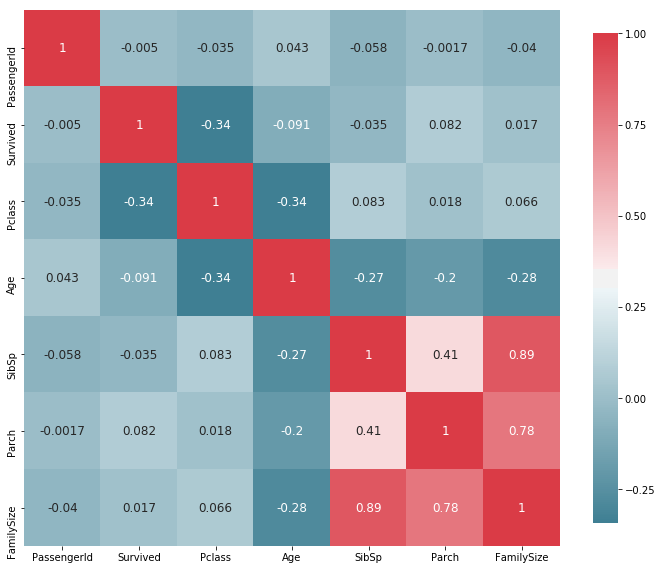

In [106]:
plot_correlation_map(df_train)

**Considerações**

- ID de passageiro (**PassengerId**) faz sentido não possuir grande correlação com as demais _features_;
- Todas _features_ com correlação alta com o campo **Survived** indica que será interessante para o treinamento;
- **Pclass** possui forte correlação com o valor da passagem (**Fare**), além de uma relação com **Age** e **Survived**;
- **Age** tem correlação com **SibSp** e **Parch**.

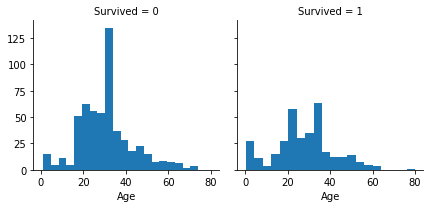

In [107]:
grid = sns.FacetGrid(df_train, col='Survived')
grid.map(plt.hist, 'Age', bins=20)
grid.add_legend()

Baseado no gráfico acima, vamos adicionar o campo **Age** no modelo

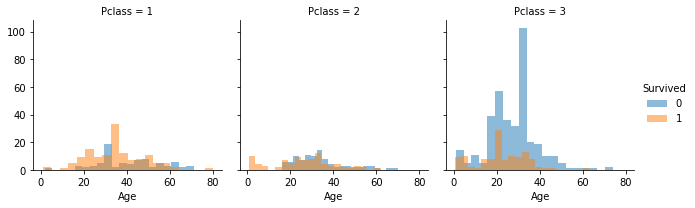

In [108]:
grid = sns.FacetGrid(df_train, col='Pclass', hue='Survived')
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


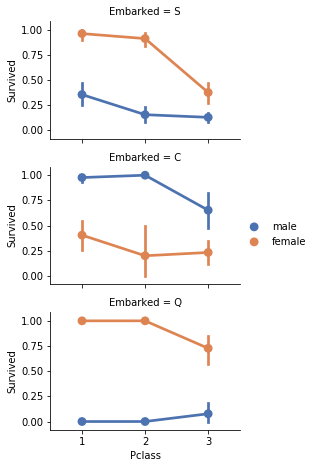

In [109]:
grid = sns.FacetGrid(df_train, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

Os campos **Pclass**, **Embarked** e **Sex** serão, também, incluidos no modelo

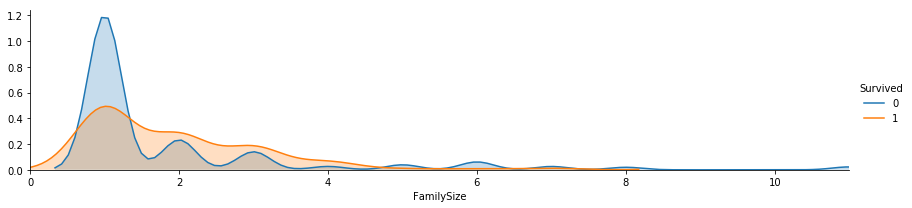

In [110]:
plot_distribution(df_train, var='FamilySize', target='Survived')

Ignorar **Fare**

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


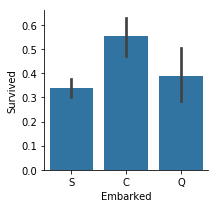

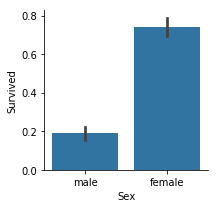

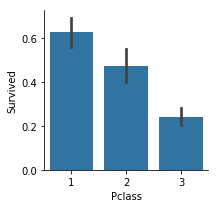

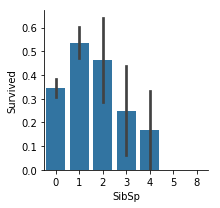

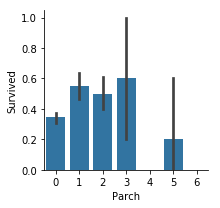

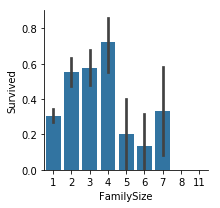

In [111]:
plot_categories(df_train, cat='Embarked', target='Survived')
plot_categories(df_train, cat='Sex', target='Survived')
plot_categories(df_train, cat='Pclass', target='Survived')
plot_categories(df_train, cat='SibSp', target='Survived')
plot_categories(df_train, cat='Parch', target='Survived')
plot_categories(df_train, cat='FamilySize', target='Survived')

## Preparação dos dados

In [0]:
sex = pd.Series(np.where(df_full.Sex=='male', 1, 0), name='Sex')
df_full['Sex'] = sex

embarked = pd.get_dummies(df_full.Embarked, prefix='Embarked')
df_full= df_full.join(embarked)

In [0]:
df_full = df_full.drop(["Embarked", "Name", "Parch", "SibSp", "Title", "PassengerId"], axis=1)
df_train = df_full[:891]
df_test = df_full[891:]

In [118]:
print(df_train.shape, df_test.shape)
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 891 to 1308
Data columns (total 8 columns):
Age           418 non-null float64
FamilySize    418 non-null int64
Pclass        418 non-null int64
Sex           418 non-null int64
Survived      0 non-null float64
Embarked_C    418 non-null uint8
Embarked_Q    418 non-null uint8
Embarked_S    418 non-null uint8
dtypes: float64(2), int64(3), uint8(3)
memory usage: 17.6 KB
None
